In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint        # for saving models
from tensorflow.keras.losses import MeanSquaredError          # loss function
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [ ]:
coupling=18.75                               # Coupling value of Kuramoto model network
num_nodes = 100
window_sizes = [5,10]                # List of window sizes to be used for training
n_epochs= 15                               # Number of epochs for training
model_name = "FCN"

In [ ]:
'''# Load the data
data = np.load(f'./Data/Degree_Radian=1.57_copling={coupling}layer2(time)VS(Node).npz')

print("Available arrays in the .npz file:", data.files)
array_key = data.files[0]                                       # Takes the first array
print(f"Using array: {array_key}")

scale_factor = 100  
array_data = data[array_key].astype(np.float32) / scale_factor

df = pd.DataFrame(array_data)
df.columns = [f'theta{i+1}' for i in range(len(df.columns))]    # Rename columns
'''

Available arrays in the .npz file: ['phases']
Using array: phases


In [ ]:
# Read and process the data, skipping the first column (time)
phase_data = []
file_path = f"/home/Najmeh/Non-hebbian/simple_kuramoto/Save/Phases/k={coupling}0000.txt"

with open(file_path, "r") as textFile:
    for line in textFile:
        values = line.strip().split()
        if len(values) > 1:
            phase_data.append(values[1:])  # Skip first column

# Convert to NumPy array WITHOUT transpose
phase_data = np.array(phase_data, dtype=float)  # Shape: (time, nodes)

# Create DataFrame: rows = time, columns = nodes
num_timesteps, num_nodes = phase_data.shape
df = pd.DataFrame(
    phase_data,
    index=[f'Time_{t}' for t in range(num_timesteps)],
    columns=[f'Node_{i}' for i in range(num_nodes)]
)

# Show part of the DataFrame
print(df.head())


In [10]:
df

,theta1,theta2,theta3,theta4,theta5,theta6,theta7,theta8,theta9,theta10,...,theta991,theta992,theta993,theta994,theta995,theta996,theta997,theta998,theta999,theta1000
0,0.36,0.32,0.41,0.41,0.46,0.23,6.19,5.99,6.21,6.06,...,4.94,4.92,4.97,5.09,5.25,5.42,5.30,3.28,2.58,6.27
1,0.45,0.41,0.49,0.49,0.54,0.31,6.26,6.06,6.27,6.14,...,4.93,4.91,4.96,5.07,5.24,5.41,5.29,3.20,2.47,6.19
2,0.55,0.50,0.57,0.57,0.61,0.38,0.06,6.14,0.05,6.22,...,4.91,4.89,4.94,5.06,5.22,5.39,5.28,3.12,2.37,6.10
3,0.65,0.60,0.66,0.65,0.69,0.46,0.14,6.22,0.12,0.02,...,4.89,4.87,4.93,5.04,5.21,5.38,5.26,3.03,2.26,6.02
4,0.75,0.69,0.74,0.74,0.76,0.54,0.21,0.01,0.19,0.10,...,4.87,4.85,4.91,5.02,5.19,5.37,5.25,2.94,2.15,5.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,4.47,1.83,4.82,2.50,5.63,1.28,0.21,5.91,5.92,4.72,...,1.06,1.05,1.33,1.18,1.19,1.17,1.18,1.27,1.86,0.87
29996,4.39,1.74,4.74,2.39,5.58,1.19,0.13,5.84,5.84,4.64,...,1.16,1.15,1.42,1.27,1.28,1.26,1.27,1.35,1.95,0.96
29997,4.30,1.65,4.65,2.29,5.53,1.11,0.06,5.77,5.77,4.55,...,1.25,1.24,1.50,1.35,1.36,1.35,1.36,1.44,2.03,1.05
29998,4.20,1.56,4.56,2.19,5.48,1.02,6.27,5.70,5.70,4.46,...,1.34,1.34,1.59,1.44,1.45,1.43,1.44,1.53,2.12,1.14


In [11]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X, y = [], []
    for i in range(len(df_as_np) - window_size):
        X.append(df_as_np[i:i + window_size])           # shape: (window_size, n_features)
        y.append(df_as_np[i + window_size])             # shape: (n_features,)
    return np.array(X), np.array(y)

In [12]:
def ann(num_nodes, window_size, model_name):
    input_layer = Input(shape=(window_size, num_nodes), dtype=tf.float32)

    # Apply cosine and sine element-wise
    cos_layer = Lambda(lambda x: tf.math.cos(x))(input_layer)
    sin_layer = Lambda(lambda x: tf.math.sin(x))(input_layer)
    x = Concatenate(axis=-1)([cos_layer, sin_layer])  # Shape: (window_size, 2*num_features)

    if model_name == "FCN":
        x = Flatten()(x)
        x = Dense(512, activation='relu')(x)
        x = Dense(256, activation='relu')(x)
        x = Dense(128, activation='relu')(x)
        #x = Dense(1280, activation='relu')(x)

    elif model_name == "LSTM": 
        x = LSTM(128)(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
   
    output = tf.keras.layers.Dense(num_nodes, activation='linear')(x)
        
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
    return model

In [ ]:
def create_and_train_model(model_name, window_size, epochs):
    # Make inputs and actual labels of them
    X, y = df_to_X_y(df, window_size)
    # Split train and test data
    X_train, y_train = X[:35000], y[:35000]
    X_val, y_val = X[35000:40000], y[35000:40000]
    X_test, y_test = X[40000:], y[40000:]
    print("Train:", X_train.shape, y_train.shape)
    print("Val:", X_val.shape, y_val.shape)
    print("Test:", X_test.shape, y_test.shape)
    num_nodes = X.shape[2]
    print("num_nodes = ", X.shape[2])

    model = ann(num_nodes, window_size, model_name)
    model.summary()
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)
    '''
    # Saving model
    model_filename = f'./Results/model_LSTM_hidden6400_J={coupling}_window{window_size}.keras'
    model.save(model_filename)'''

    # Make predictions
    predictions = model.predict(X_test)
    print(predictions)
    
    os.makedirs("./Results", exist_ok=True)
    np.savetxt(f"./Results/J={coupling}_window{window_size}_actual.txt", y_test, fmt='%.2f', delimiter='\t', newline='\n', encoding=None)
    np.savetxt(f"./Results/J={coupling}_window{window_size}_predicted.txt", predictions, fmt='%.2f', delimiter='\t', newline='\n', encoding=None)

    return history, predictions

In [14]:
# Dictionary to store training histories for each window size
histories = {}

for window_size in window_sizes:
    print(f"Training model with window size: {window_size}")
    history,_ = create_and_train_model(model_name, window_size, n_epochs)   # Create and train the model with the current window size
    histories[window_size] = history    

Training model with window size: 5
Train: (20000, 5, 1000) (20000, 1000)
Val: (5000, 5, 1000) (5000, 1000)
Test: (4995, 5, 1000) (4995, 1000)
num_nodes =  5



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 1000)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 5, 1000)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 5, 1000)   │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 2000)   │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 10000)     │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  5,120,512 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1000)      │    129,000 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,413,736 (20.65 MB)

 Trainable params: 5,413,736 (20.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 70ms/step - loss: 4.3980 - root_mean_squared_error: 2.0252 - val_loss: 1.4375 - val_root_mean_squared_error: 1.1990
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - loss: 1.3699 - root_mean_squared_error: 1.1704 - val_loss: 1.3371 - val_root_mean_squared_error: 1.1563
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 74ms/step - loss: 1.2412 - root_mean_squared_error: 1.1141 - val_loss: 1.2592 - val_root_mean_squared_error: 1.1222
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 72ms/step - loss: 1.1494 - root_mean_squared_error: 1.0721 - val_loss: 1.2093 - val_root_mean_squared_error: 1.0997
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 75ms/step - loss: 1.0772 - root_mean_squared_error: 1.0379 - val_loss: 1.1752 - val_root_mean_squared_error: 1.0841
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 47s 74ms/step - loss: 1.0333 - root_mean_squared_error: 1.0165 - val_loss: 1.1466 - val_root_mean_squared_error: 1.0708
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 10, 1000)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 10, 1000)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 10, 1000)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 10, 2000)  │          0 │ lambda_2[0][0],   │
│ (Concatenate)       │                   │            │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 20000)     │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │ 10,240,512 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 256)       │    131,328 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     32,896 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1000)      │    129,000 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,533,736 (40.18 MB)

 Trainable params: 10,533,736 (40.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 112ms/step - loss: 4.3035 - root_mean_squared_error: 2.0022 - val_loss: 1.4386 - val_root_mean_squared_error: 1.1994
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 108ms/step - loss: 1.3574 - root_mean_squared_error: 1.1650 - val_loss: 1.3309 - val_root_mean_squared_error: 1.1536
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 70s 112ms/step - loss: 1.2344 - root_mean_squared_error: 1.1110 - val_loss: 1.2805 - val_root_mean_squared_error: 1.1316
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - loss: 1.1554 - root_mean_squared_error: 1.0749 - val_loss: 1.2173 - val_root_mean_squared_error: 1.1033
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step - loss: 1.0919 - root_mean_squared_error: 1.0449 - val_loss: 1.1867 - val_root_mean_squared_error: 1.0894
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - loss: 1.0320 - root_mean_squared_error: 1.0159 - val_loss: 1.1652 - val_root_mean_squared_error: 1.0794
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━

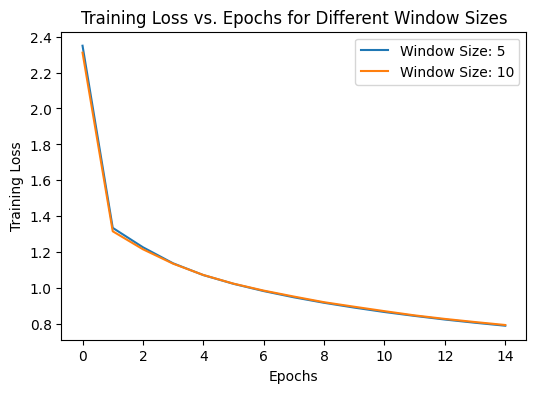

In [15]:
plt.figure(figsize=(6, 4))

for window_size, history in histories.items():
    plt.plot(history.history['loss'], label=f'Window Size: {window_size}')

plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs for Different Window Sizes')
plt.legend()
plt.savefig(f'./Results/training_loss_vs_epochs_J={coupling}.png')
plt.show()

In [16]:
def plot_results(window_size):


    # Define the colors for the custom cyclic colormap
    colors = [
        (1.0, 0.0, 1.0),  # Magenta (255, 0, 255)
        (1.0, 0.0, 0.0),  # Red (255, 0, 0)
        (1.0, 1.0, 0.0),  # Yellow (255, 255, 0)
        (0.0, 1.0, 0.0),  # Green (0, 255, 0)
        (0.0, 1.0, 1.0),  # Cyan (0, 255, 255)
        (0.0, 0.0, 1.0),  # Blue (0, 0, 255)
        (1.0, 0.0, 1.0)   # Magenta (255, 0, 255)
    ]

    # Create the custom cyclic colormap
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

    fig = plt.figure()

    # _________________________________________________________
    ax_1 = plt.subplot(3, 4, (1, 4))
    # Read the input data
    with open(f"./Results/J={coupling}_window{window_size}_actual.txt") as textFile:  # ./Results/J={coupling}_actual.txt
        lines = [line.split() for line in textFile]
    lines = np.array(lines, dtype=float).transpose()  # Convert to numpy array and transpose


    # Subtract 2*pi from values greater than pi
    #lines = np.where(lines > np.pi, lines - 2 * np.pi, lines)
    # Add 2*pi to values less than -pi
    #lines = np.where(lines < -np.pi, lines + 2 * np.pi, lines)

    print(np.min(lines))
    print(np.max(lines))


    # plot
    vmin = 0
    vmax = 2*np.pi
    plt.imshow(lines, cmap=custom_cmap, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(ticks=[vmin, 0, vmax])
    #cbar.ax.set_yticklabels(['-π', '0', 'π'])

    plt.title(f'Comparision (window {window_size})', fontsize=10)

    # plot
    # Customize tick parameters
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=10,
                    labelcolor='#262626')
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize=10,
                    labelcolor='#262626')
    # Reverse the y-axis direction
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    # Set x and y limits
    plt.xlim(0, len(lines[0]))
    plt.ylim(0, num_nodes)
    # Set labels
    plt.ylabel('Node (i)', fontsize=10, labelpad=10)
    plt.xlabel('Time (s)', fontsize=10)
    # _________________________________________________________

    ax_2 = plt.subplot(3, 4, (5, 8))

    # Read the input data
    with open(f"./Results/J={coupling}_window{window_size}_predicted.txt") as textFile:
        lines2 = [line.split() for line in textFile]
    lines2 = np.array(lines2, dtype=float).transpose()  # Convert to numpy array and transpose

    # Subtract 2*pi from values greater than pi
    lines2 = np.where(lines2 > 2*np.pi, lines2 - 2 * np.pi, lines2)
    # Add 2*pi to values less than -pi
    lines2 = np.where(lines2 < 0, lines2 + 2 * np.pi, lines2)

    print(np.min(lines2))
    print(np.max(lines2))
    # plot
    vmin = 0
    vmax = 2*np.pi
    plt.imshow(lines2, cmap=custom_cmap, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(ticks=[vmin, 0, vmax])
    #cbar.ax.set_yticklabels(['-π', '0', 'π'])

    # plot
    # Customize tick parameters
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=10,
                    labelcolor='#262626')
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize=10,
                    labelcolor='#262626')
    # Reverse the y-axis direction
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    # Set x and y limits
    plt.xlim(0, len(lines2[0]))
    plt.ylim(0, num_nodes)
    # Set labels
    plt.ylabel('Node (i)', fontsize=10, labelpad=10)
    plt.xlabel('Time (s)', fontsize=10)
    # _________________________________________________________
    def kuramoto_similarity(theta1, theta2):
        z1 = np.exp(1j * theta1)
        z2 = np.exp(1j * theta2)
        return np.abs((z1 + z2) / 2)


    '''def phase_similarity(theta1, theta2):
        delta = np.angle(np.exp(1j * (theta1 - theta2)))  # in range [-π, π]
        distance = np.abs(delta)  # in range [0, π]
        similarity = 1 - (distance / np.pi)  # normalize to [0, 1]
        return similarity'''
    s = (len(lines[:, 0]),len(lines[0, :]))
    lines3 = np.zeros(s)
    ax_3 = plt.subplot(3, 4, (9, 12))
    for i in range(lines.shape[0]):
        for j in range(lines.shape[1]):
            lines3[i][j] = kuramoto_similarity(lines2[i][j] ,lines[i][j])

    print(np.min(lines3))
    print(np.max(lines3))
    # plot
    plt.imshow(lines3, cmap='binary', aspect='auto', interpolation='nearest')
    cbar = plt.colorbar(ticks=[-1.001, 0, 1])
    # cbar.ax.set_yticklabels(['-1', '0', '1'])
    # Customize tick parameters
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labeltop=False, labelsize=10,
                    labelcolor='#262626')
    plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False, labelsize=10,
                    labelcolor='#262626')
    # Reverse the y-axis direction
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
    # Set x and y limits
    plt.xlim(0, len(lines3[0]))
    print(len(lines3[0]))
    plt.ylim(0, num_nodes)
    # Set labels
    plt.ylabel('Node (i)', fontsize=10, labelpad=10)
    plt.xlabel('Time (s)', fontsize=10)
    # Save the figure as a .png file
    plt.subplots_adjust(top=0.97, bottom=0.08, hspace=0.3, wspace=0.44)


    plt.gcf().set_size_inches(12, 3)
    #plt.savefig(f'/content/drive/My Drive/Colab Notebooks/Forecasting phases project/Results/result_J={coupling}_window{window_size}.pdf')
    plt.savefig(f'./Results/result_J={coupling}_window{window_size}.png' , dpi=300)

0.0
6.28
0.0
6.28
0.0007963267107328854
1.0000000000000002
4995
0.0
6.28
0.0
6.28
0.0007963267107330101
1.0000000000000002
4990


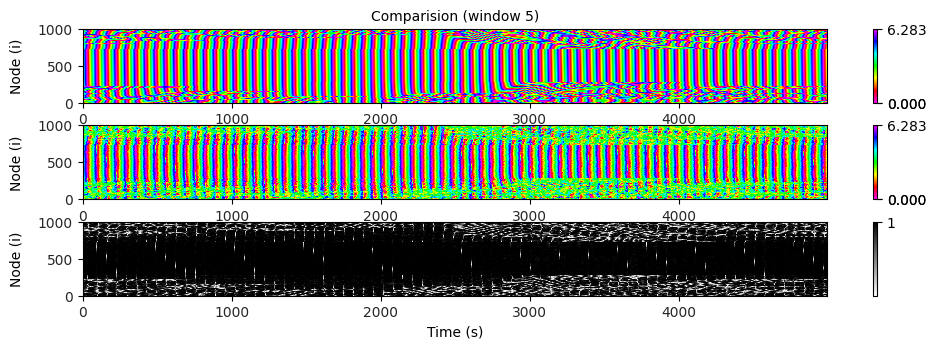

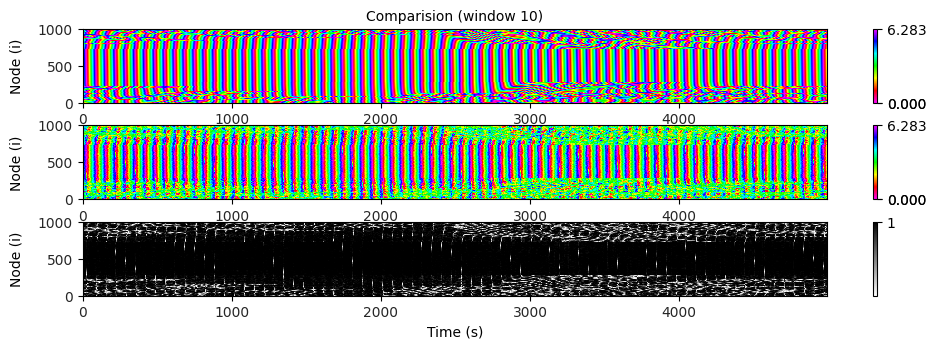

In [17]:
for window_size in window_sizes:
    plot_results(window_size)